In [74]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import scipy.optimize as opt

### 1 Anomaly detection

In [2]:
data1 = io.loadmat('./data/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

(307, 2)


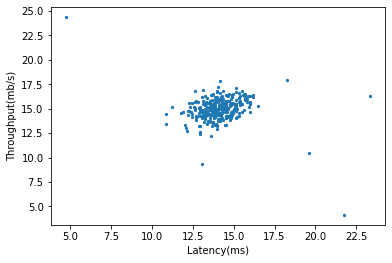

In [3]:
X1 = data1['X']
print(X1.shape)
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.show()

#### 1.1 Gaussian distribution
Given a training set $\{x^{(1)},...,x^{(m)}\}$(where $X^{(i)}\in\mathbb{R}^n$), you want to estimate the Gaussian distribution for each of the features $x_i$. For each feature $i=1...n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i^{th}$ dimension $\{x_i^{(1)},...,x_i^{(m)}\}$(the $i^{th} dimension of each example$).
The Gaussian distribution is given by$$p(x;\mu,\sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$where $\mu$ is the mean and $\sigma^2$ controls the variance.

#### 1.2 Estimating parameters for a Gaussian
You can estimata the parameters, $(\mu_i.\sigma_i^2)$, of the $i^{th}$ deature by using the following equations. To estimate the mean, you can use:$$\mu_i=\frac{1}{m}\sum\limits_{j=1}^{m}x_i^{(j)}$$and for the variance you can use:$$\sigma_i^2=\frac{1}{m}\sum\limits_{j=1}^{m}(x_i^{(j)}-\mu_j)^2$$

In [4]:
def estimateGaussian(X):
    return np.mean(X, axis=0), np.var(X, axis=0)

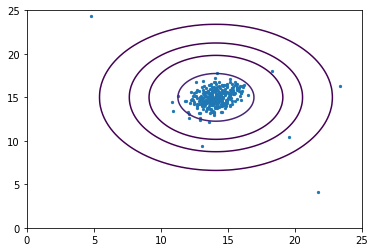

In [5]:
mu, sigma2 = estimateGaussian(X1)

plt_x = np.linspace(0, 25, 250)
plt_y = np.linspace(0, 25, 250)
plt_x, plt_y = np.meshgrid(plt_x, plt_y)
plt_z = np.exp((-0.5)*((plt_x-mu[0])**2/sigma2[0]+(plt_y-mu[1])**2/sigma2[1])) / (2*np.pi*np.sqrt(sigma2[0]*sigma2[1]))
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.contour(plt_x, plt_y, plt_z, [10e-11, 10e-7, 10e-5, 10e-3, 0.1])
plt.show()

#### 1.3 Selecting the threshold
You will implement an algorithm to select the threshold " using the $F_1$ score on a cross validation set. For this, we will use a cross validation set $\{(x_{cv}^{(1)},y_{cv}^{(1)}),...,(x_{cv}^{(m_{cv})},y_{cv}^{(m_{cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresonds to a normal example. The $F_1$ score is computed using precision(prec) and recall(rec):$$F_1=\frac{2\cdot prec\cdot rec}{prec+rec}$$You compute precision and recall by:$$prec=\frac{tp}{tp+fp},rec=\frac{tp}{tp+fn}$$
- $tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.
- $fp$ is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In [6]:
X1_val = data1['Xval']
y1_val = data1['yval']
X1_val.shape, y1_val.shape

((307, 2), (307, 1))

In [7]:
def computeP(X, mu, sigma2):
    """
    X-mxn, mu-nx1, sigma2-nx1
    """
    n = len(mu)
    p = np.empty((X.shape[0], X.shape[1]))

    for i in range(n):
        p[:, i] = 1 / np.sqrt(2*np.pi*sigma2[i]) * np.exp(-np.power((X[:, i]-mu[i]), 2) / (2 * sigma2[i]))
    def singleP(x):
        p = 1
        for i in range(len(x)):
            p *= x[i]
        return p
    
    return np.apply_along_axis(singleP, 1, p)

In [8]:
def selectThreshold(pval, yval):
    """
    pval-mx1 & yval-mx1
    """
    best_epsilon = 0
    best_F1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1))
        fp = np.sum(np.logical_and(preds == 1, yval == 0))
        fn = np.sum(np.logical_and(preds == 0, yval == 1))
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)

        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1   

In [9]:
pval = computeP(X1, mu, sigma2)
epsilon, F1 = selectThreshold(pval, y1_val.ravel())
epsilon, F1

/tmp/ipykernel_10324/1266961854.py:14: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp + fp)


(8.986095083415362e-05, 0.8)

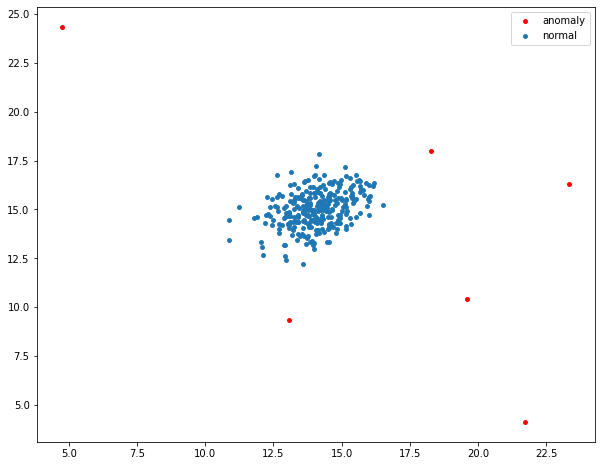

In [10]:
pval = computeP(X1, mu, sigma2)
anomaly = X1[pval < epsilon]
normal = X1[pval > epsilon]
plt.figure(figsize=(10, 8))
plt.scatter(anomaly[:, 0], anomaly[:, 1], s=15, label='anomaly', c='r')
plt.scatter(normal[:, 0], normal[:, 1], s=15, label='normal')
plt.legend()
plt.show()

#### 1.4 High dimensional data

In [11]:
data2 = io.loadmat('./data/ex8data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [12]:
X2 = data2['X']
X2_val = data2['Xval']
y2_val = data2['yval']
X2.shape, X2_val.shape, y2_val.shape

((1000, 11), (100, 11), (100, 1))

In [13]:
mu, sigma2 = estimateGaussian(X2)
pval = computeP(X2_val, mu, sigma2)
epsilon, _ = selectThreshold(pval, y2_val.ravel())
pval = computeP(X2, mu, sigma2)
print(f'Best epsilon is {epsilon} and the number of anomalies found is {np.sum(pval < epsilon)}')

Best epsilon is 1.377228890761357e-18 and the number of anomalies found is 117


/tmp/ipykernel_10324/1266961854.py:14: RuntimeWarning: invalid value encountered in long_scalars
  prec = tp / (tp + fp)


### 2 Recommender Systems

#### 2.1 Movie ratings data
The matrix $Y(num\_movies\times num\_users)$ stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix $R$ ia an binary-valued indicator matrix, where $R(i,j)=1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise.
Throughout this part of the exercise, you will also be working with the matrices, $X$ and $Theta$:$$X=\begin{bmatrix}-(x^{(1)})^T-\\-(x^{(2)})^T-\\\vdots\\-(x^{(x_m)})^T-\end{bmatrix},\Theta=\begin{bmatrix}-(\theta^{(1)})^T-\\-(\theta^{(2)})^T-\\\vdots\\-(\theta^{(n_u)})^T-\end{bmatrix}$$The $i^{th}$ row of $X$ is corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of $Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors.

In [17]:
data_mr = io.loadmat('./data/ex8_movies.mat')
data_mr.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

#### 2.2 Collaborative filtering learning algorithm
##### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function is given by$$J(x^{(1)},...,x^{(n_{m})},\theta^{(1)},...,\theta^{(n_{u})})=\frac{1}{2}\sum\limits_{(i,j):r(i,j)=1}\left((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)}\right)^{2}+\frac{\lambda}{2}\sum\limits_{j=1}^{n_{u}}\sum\limits_{k=1}^n(\theta_{k}^{(j)})^{2}+\frac{\lambda}{2}\sum\limits_{i=1}^{n_{m}}\sum\limits_{k=1}^{n}(x_{k}^{(i)})^{2}$$Note that you should be accumulating the cost for user $j$ and movie $i$ only if $R(i,j)=1$.

Note that the parameters to the function are $X$ and $Theta$. In order to use an off-the-shelf minimizer such as fmincg, the cost function has benn set up to unroll the parameters into a single vector params.

In [30]:
Y = data_mr['Y']
R = data_mr['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [68]:
def serialize(X, Theta):
    return np.concatenate((X.ravel(), Theta.ravel()))

def deserialize(params, n_movie, n_user, n_feature):
    X = params[:n_movie * n_feature].reshape(n_movie, n_feature)
    Theta = params[n_movie * n_feature:].reshape(n_user, n_feature)

    return X, Theta

In [66]:
def cost(params, Y, R, n_feature, lamd=0):
    """compute cost for only R(i,j)=1
    Args:
        params: serialized X, Theta
        Y(n_movie, n_user): (moive, user) rating
        R(n_movie, n_user): (moive, user) has rating
    """
    n_movie, n_user = Y.shape
    X, Theta = deserialize(params, n_movie, n_user, n_feature)

    err = (X @ Theta.T - Y) * R
    inner = np.sum(np.power(err, 2)) + lamd*(np.sum(np.power(params, 2)))
    return inner / 2

In [33]:
data_params = io.loadmat('./data/ex8_movieParams.mat')
data_params.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [69]:
X, Theta, n_feature = data_params['X'], data_params['Theta'], int(data_params['num_features'])
n_user, n_movie = int(data_params['num_users']), int(data_params['num_movies'])
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]
params_sub = serialize(X_sub, Theta_sub)
params = serialize(X, Theta)

cost(params_sub, Y_sub, R_sub, features, 0)
cost(params_sub, Y_sub, R_sub, features, 1.5)

31.34405624427422

##### 2.2.2 Collaborative filtering gradient
`X_grad` should be a matrix of the same size as `X` and similarly `Theta_grad` is a matrix of the same size as `Theta`. The gradients of the cost function is given by:
$$\frac{\partial J}{\partial x_k^{(i)}}=\sum\limits_{j:r(i,j)=1}\left((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)}\right)\theta_{k}^{(j)}+\lambda x_{k}^{(i)}$$
$$\frac{\partial J}{\partial\theta_k^{(j)}}=\sum\limits_{i:r(i,j)=1}\left((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)}\right)x_{k}^{(i)}+\lambda\theta_{k}^{(j)}$$
Note that the function returns the gradients for both sets of variables by unrolling them into a single vector.

In [70]:
def gradient(params, Y, R, n_feature, lamd=0):
    n_movie, n_user = Y.shape
    X, Theta = deserialize(params, n_movie, n_user, n_feature)

    inner = (X @ Theta.T - Y) * R
    X_grad = inner @ Theta + lamd * X
    Theta_grad = inner.T @ X + lamd * Theta
    
    return serialize(X_grad, Theta_grad)

#### 2.3 Learning movie recommendations

In [72]:
def initXandTheta(n_movie, n_user, n_feature):
    X = np.random.random((n_movie, n_feature))
    Theta = np.random.random((n_user, n_feature))

    return X, Theta

In [78]:
X, Theta = initXandTheta(n_movie, n_user, n_feature)
params = serialize(X, Theta)
params_opt = opt.fmin_tnc(func=cost, x0=params, fprime=gradient, args=(Y, R, n_feature, 1.5))
params_opt

  NIT   NF   F                       GTG
    0    1  1.455157331461225E+05   1.28890227E+08
tnc: fscale = 6.05544e-05
    1    7  6.847656944619790E+04   1.31431962E+07
tnc: stepmx = 1000
    2   14  5.192757318226712E+04   1.66632355E+06
    3   27  4.632230256242627E+04   6.64256629E+05
    4   42  4.293838483519736E+04   1.27129657E+06
    5   70  3.943453810032790E+04   1.43389021E+06
    6   79  3.706131618636110E+04   2.31099802E+05
tnc: fscale = 0.0013495
    7  119  3.561112354840086E+04   2.88452560E+05
    8  126  3.456381178899940E+04   6.55228025E+04
    9  185  3.411648464742900E+04   7.26687764E+04
   10  196  3.353116833608175E+04   2.36120247E+04
   11  217  3.325547152506690E+04   7.91363426E+03
   12  236  3.314073893280773E+04   4.66281782E+03
   13  251  3.307945376323331E+04   2.38657636E+03
   14  306  3.301369350117845E+04   3.32663627E+03
   15  312  3.298772877369910E+04   1.28903581E+03
   16  339  3.294031859969202E+04   1.17101689E+03
   17  354  3.292408796

(array([0.76190311, 0.84151436, 0.64452165, ..., 1.07716184, 0.84944982,
        0.23052471]),
 2868,
 1)

   99 2868  3.276817095037663E+04   6.86364897E-07
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [81]:
params_opt[0]
X_opt, Theta_opt = deserialize(params_opt[0], n_movie, n_user, n_feature)

In [118]:
movie_lists = []
with open('./data/movie_ids.txt', encoding='ISO-8859-1') as f:
    for line in f:
        # strip() 函数用于移除字符串头尾指定的字符（默认为空格或换行符）或字符序列。
        tokens = line.strip().split(' ')
        movie_lists.append(' '.join(tokens[1:]))

movie_lists = np.array(movie_lists)

In [122]:
Y_pred = X_opt @ Theta_opt.T
idx = np.argsort(Y_pred[:, 0])[::-1]
my_rat = Y_pred[:, 0][idx][:10]
my_fav = movie_lists[idx][:10]

In [124]:
print('Top recommendations for you:')
for i in range(10):
    print(f'Predicting rating {round(my_rat[i], 1)} for movie {my_fav[i]}')

Top recommendations for you:
Predicting rating 5.7 for movie Contact (1997)
Predicting rating 5.6 for movie Wings of Desire (1987)
Predicting rating 5.6 for movie Star Wars (1977)
Predicting rating 5.6 for movie Close Shave, A (1995)
Predicting rating 5.6 for movie Wrong Trousers, The (1993)
Predicting rating 5.5 for movie Down by Law (1986)
Predicting rating 5.5 for movie L.A. Confidential (1997)
Predicting rating 5.4 for movie Wallace & Gromit: The Best of Aardman Animation (1996)
Predicting rating 5.4 for movie Leaving Las Vegas (1995)
Predicting rating 5.3 for movie Ran (1985)
